## Packages Import and global model variable assignment
Also fetch local openAI api key

In [1]:
import pandas as pd
import numpy as np
import os
import openai as ai
import xgboost as xgb
import sklearn as sl


ai.api_key = os.environ.get('AI_API_KEY')


## Data Download and Cleaning

In [2]:
from functions import downloadData

path = (r'C:\Users\Luke\Downloads\reviews_Electronics_5.json')

data = downloadData(path = path, n = 10000)

In [3]:
data.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"


In [4]:
from functions import transformData

transformed_data = transformData(data = data)

In [5]:
transformed_data.head(3)

,overall,helpful_ratio,overall_positive,excellent,good,great,impressive,satisfactory,outstanding,fantastic,...,troublesome,detestable,abominable,repugnant,lamentable,revolting,displeasing,dismaying,termination,apprehensive
0,4,0.00,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0.93,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Data Exploration

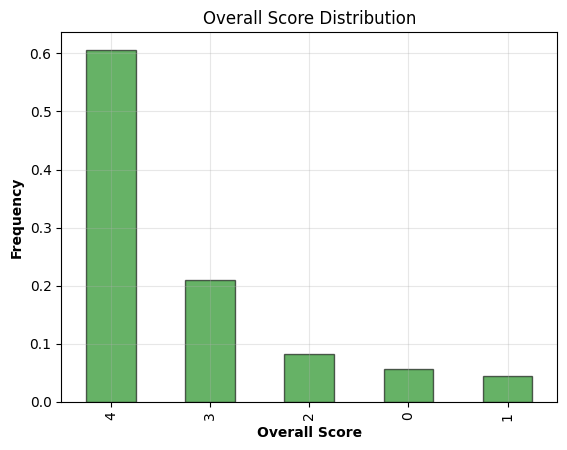

In [6]:
from utils import frequencyHistogram

frequencyHistogram("overall", transformed_data)

## Modelling and Cross Validation
We go over the binary GBM, score GBM, binary GPT, and score GPT

In [7]:
response_var_binary = transformed_data['overall_positive']
response_var = transformed_data['overall']
predictor_var = transformed_data.drop(['overall_positive', 'overall'], axis = 1)

**Binary GBM**

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(predictor_var, response_var_binary, test_size=0.1, random_state=42)

xgb_classifier = XGBClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs = -1)

grid_search.fit(X_train_binary, Y_train_binary)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


In [9]:
from xgboost import XGBClassifier

#Dataset is unbalnced so we need to adjust weights in scale_pos_weight to account for probabibalistic bias to positive.
model_binary = XGBClassifier(objective = 'binary:logistic', eval_metric = 'rmse', n_estimators = 600, learning_rate = 0.05, max_depth = 4, colsample_bytree = 1, subsample = 0.9, scale_pos_weight = (9000-sum(Y_train_binary)) / sum(Y_train_binary))

model_binary.fit(X_train_binary, Y_train_binary)
predictions_binary = model_binary.predict(X_test_binary)

**Binary ChatGPT**

First we set up the test dataframe and predictions dataframe

In [10]:
#We need to join reviewText and summary as these are the predictors for chat GPT.
X_test_binary_gpt = X_test_binary.join(data[['reviewText',"summary"]]).sort_index(ascending=True)

predictions_binary_gpt_df = pd.DataFrame(columns=['prediction_binary', 'prediction'])

In [64]:
from functions import fetchGPT

#We need to run this multiple times until all prompts predicted.

X_test_binary_gpt, predictions_binary_gpt_df = fetchGPT(X_test_binary_gpt, predictions_binary_gpt_df, Y_test_binary)

#Only use predictions when we have all of them computed.
predictions_binary_gpt = predictions_binary_gpt_df['prediction_binary'].to_list() if len(Y_test_binary) == len(predictions_binary_gpt_df) else None



**Score GBM**

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, Y_train, Y_test = train_test_split(predictor_var, response_var, test_size=0.1, random_state=42)

xgb_classifier = XGBClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs = -1)

grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [80]:
from xgboost import XGBClassifier

#Dataset is unbalnced so we need to adjust weights in scale_pos_weight to account for probabibalistic bias to positive.
model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'rmse', n_estimators = 300, learning_rate = 0.01, max_depth = 4, colsample_bytree = 0.9, subsample = 0.9)

model.fit(X_train, Y_train)
predictions = model.predict(X_test)

**Score ChatGPT**

In [81]:
#We need to join reviewText and summary as these are the predictors for chat GPT.
X_test_gpt = X_test.join(data[['reviewText',"summary"]]).sort_index(ascending=True)

predictions_gpt_df = pd.DataFrame(columns=['prediction_binary', 'prediction'])

In [127]:
from functions import fetchGPT

#We need to run this multiple times until all promps predicted.

X_test_gpt, predictions_gpt_df = fetchGPT(X_test_gpt, predictions_gpt_df, Y_test)

#Only use predictions when we have all of them computed.
predictions_gpt = predictions_gpt_df['prediction'].to_list() if len(Y_test) == len(predictions_gpt_df) else None


## Model Diagnostics
**Binary GBM**

In [67]:
from utils import accuracy

accuracy(Y_test_binary, predictions_binary)

Accuracy: 0.742
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.71      0.34        91
           1       0.96      0.74      0.84       909

    accuracy                           0.74      1000
   macro avg       0.59      0.73      0.59      1000
weighted avg       0.90      0.74      0.79      1000



In [68]:
from utils import confusionMatrix

confusionMatrix(Y_test_binary, predictions_binary)

Confusion Matrix:

False Positives: 26
False Negatives: 232
True Positives: 677
True Negatives: 65


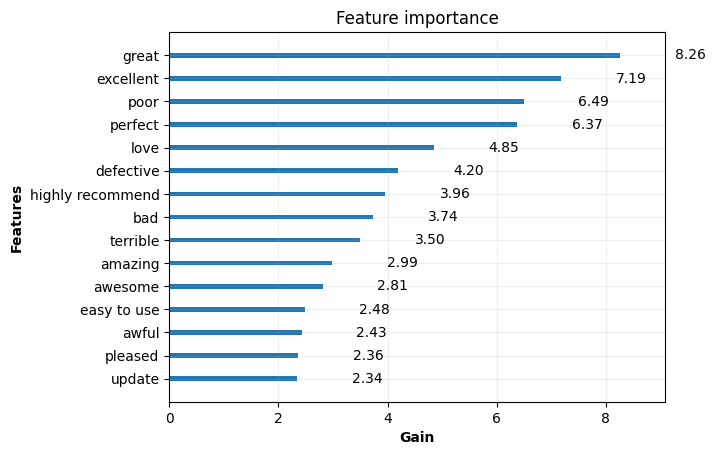

In [69]:
from utils import importance

importance(model_binary)
   

**Chat GPT Binary**

In [75]:
from utils import accuracy

accuracy(Y_test_binary, predictions_binary_gpt)

Accuracy: 0.831
Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.03      0.03        91
           1       0.90      0.91      0.91       909

    accuracy                           0.83      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.82      0.83      0.83      1000



In [76]:
from utils import confusionMatrix

confusionMatrix(Y_test_binary, predictions_binary_gpt)

Confusion Matrix:

False Positives: 88
False Negatives: 81
True Positives: 828
True Negatives: 3


**Score GBM**

In [128]:
from utils import accuracy

accuracy(Y_test, predictions)

Accuracy: 0.621
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.02      0.03        55
           1       0.18      0.06      0.09        36
           2       0.50      0.01      0.02        85
           3       0.25      0.02      0.04       207
           4       0.63      0.99      0.77       617

    accuracy                           0.62      1000
   macro avg       0.36      0.22      0.19      1000
weighted avg       0.51      0.62      0.49      1000



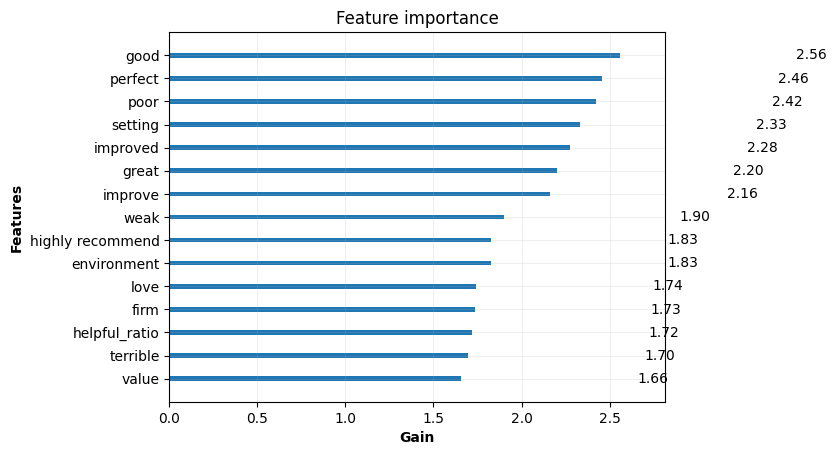

In [ ]:
from utils import importance

importance(model)
   

**Chat GPT Score**

In [138]:
from utils import accuracy

accuracy(Y_test, predictions_gpt)

Accuracy: 0.35
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.03      0.06      0.04        36
           2       0.08      0.08      0.08        85
           3       0.21      0.44      0.29       207
           4       0.63      0.40      0.49       617

    accuracy                           0.35      1000
   macro avg       0.19      0.20      0.18      1000
weighted avg       0.44      0.35      0.37      1000

